In [187]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
device = 'cuda:0'
torch.manual_seed(0)
torch.cuda.is_available()

True

In [321]:
# Force Field
class ForceField(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ForceField, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.activation = nn.Sigmoid()
        self.layer2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.layer1(x)
        x = self.activation(x)
        x = self.layer2(x)
        return x

In [322]:
# Atom Coordinates
class AtomCoordinates(nn.Module):
    def __init__(self, num_atoms):
        super(AtomCoordinates, self).__init__()
        self.coordinates = nn.Parameter(torch.randn(num_atoms)*10)

    def forward(self):
        return self.coordinates

In [568]:
# Data
def lennard_jones_potential(r, eps=1e-1):
    return 1 / (r+eps)**12 - 1 / (r+eps)**6

def distances_matrix(coordinates):
    matrix_size = coordinates.shape[0]
    distances = torch.cdist(coordinates.view(-1, 1), coordinates.view(-1, 1))
    indices = torch.triu_indices(matrix_size, matrix_size, offset=1)
    distances = distances[indices[0], indices[1]]
    return distances

def simulate_stable_conformations(atom_coordinates, force_field, num_iterations=1000, lr=0.01):
    optimizer = optim.Adam([atom_coordinates], lr=lr)
    
    for iteration in range(num_iterations):
        potential_energy = torch.sum(force_field(distances_matrix(atom_coordinates).view(-1, 1)))

        optimizer.zero_grad()
        potential_energy.backward()
        torch.nn.utils.clip_grad_norm_(atom_coordinates, 1)
        optimizer.step()

#         if iteration % 1000 == 0:
#             print(f"Iteration {iteration}, Potential Energy: {potential_energy.item()}")

    return atom_coordinates

In [593]:
# Train
def train(force_field, atom_coordinates, stable_conformations, num_iterations=1000):
    atom_optimizer = optim.Adam(atom_coordinates.parameters(), lr=0.01)
    force_optimizer = optim.Adam(force_field.parameters(), lr=0.01)
    
    for iteration in range(num_iterations):
        # Simulate
        atom_stable = AtomCoordinates(100)
        stable_conformations = simulate_stable_conformations(atom_stable(), lennard_jones_potential, num_iterations=5000).detach()
        
        # Atom Coordinates
        for loop in range(3000):
            potential_energy = torch.sum(force_field(distances_matrix(atom_coordinates.coordinates).view(-1, 1)))
            atom_optimizer.zero_grad()
            potential_energy.backward()
            torch.nn.utils.clip_grad_norm_(atom_coordinates.parameters(), 0.1)
            atom_optimizer.step()
            
            if loop % 1000 == 0:
                print(f"    Loop {loop}, Potential Energy: {potential_energy.item()}")

        # Force Field
        tempor_conformations = atom_coordinates.coordinates.clone().detach()
        for loop in range(3000):
            farway_conformations = 10 * torch.randn_like(tempor_conformations)
            temp_energy = torch.sum(force_field(distances_matrix(tempor_conformations).view(-1, 1)))        
            true_energy = torch.sum(force_field(distances_matrix(stable_conformations).view(-1, 1)))
            away_energy = torch.sum(force_field(distances_matrix(farway_conformations).view(-1, 1)))
            energy_difference = true_energy - temp_energy
            loss_energy = energy_difference + 10 * torch.abs(away_energy)
            force_optimizer.zero_grad()
            loss_energy.backward()
            torch.nn.utils.clip_grad_norm_(force_field.parameters(), 0.1)
            force_optimizer.step()
            
            if loop % 1000 == 0:
                print(f"    Loop {loop}, Energy Difference: {energy_difference.item()}")

        # Print progress
        if iteration % 1 == 0:
            print(f"Iteration {iteration}, Potential Energy: {potential_energy.item()},  Energy Difference: {energy_difference.item()}")

In [589]:
num_atoms = hidden_size = 100
atom_stable = AtomCoordinates(num_atoms)
stable_conformations = simulate_stable_conformations(atom_stable(), lennard_jones_potential, num_iterations=5000)

In [594]:
atom_coordinates = AtomCoordinates(num_atoms)
force_field = ForceField(1, hidden_size, 1)
train(force_field, atom_coordinates, stable_conformations.clone().detach(), 5)

Loop 0, Potential Energy: 3680.3681640625
Loop 1000, Potential Energy: 3391.8271484375
Loop 2000, Potential Energy: 3350.41796875
Loop 0, Energy Difference: 288.425537109375
Loop 1000, Energy Difference: -210359.046875
Loop 2000, Energy Difference: -604271.3125
Iteration 0, Potential Energy: 3308.54931640625,  Energy Difference: -1128515.5
Loop 0, Potential Energy: 1010931.3125
Loop 1000, Potential Energy: -102401.921875
Loop 2000, Potential Energy: -121347.75
Loop 0, Energy Difference: 7594.1796875
Loop 1000, Energy Difference: 3111.3671875
Loop 2000, Energy Difference: 1219.3125
Iteration 1, Potential Energy: -126058.109375,  Energy Difference: 495.6484375
Loop 0, Potential Energy: -47920.734375
Loop 1000, Potential Energy: -47961.2578125
Loop 2000, Potential Energy: -47964.0625
Loop 0, Energy Difference: 537.82421875
Loop 1000, Energy Difference: 114.193359375
Loop 2000, Energy Difference: -163.05859375
Iteration 2, Potential Energy: -47964.08203125,  Energy Difference: -464.3808593

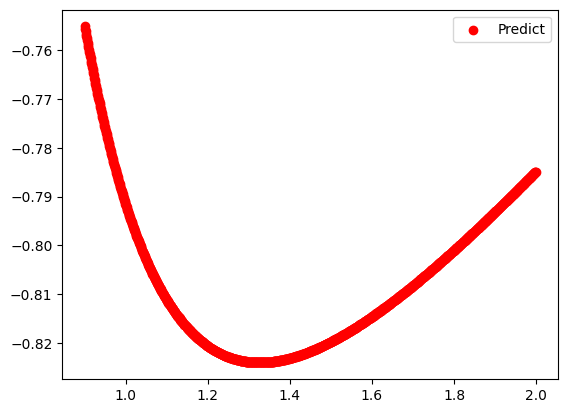

In [597]:
x_data = torch.arange(0.9, 2.0, 0.001)
y_real = lennard_jones_potential(x_data)
y_pred = force_field(x_data.view(-1, 1)).detach()

# plt.scatter(x_data.numpy(), y_real.numpy(), label='Real')
plt.scatter(x_data.numpy(), y_pred.numpy(), label='Predict', color='red')
plt.legend()
plt.show()

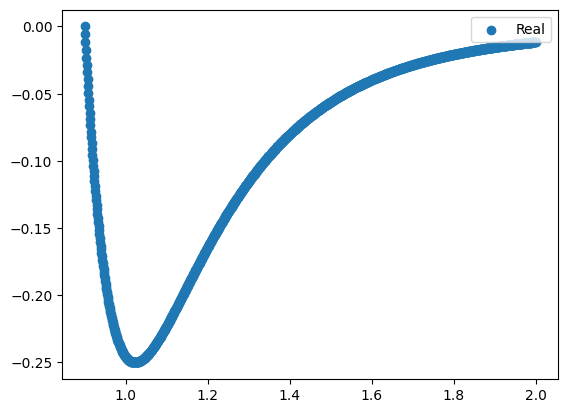

In [598]:
x_data = torch.arange(0.9, 2.0, 0.001)
y_real = lennard_jones_potential(x_data)
y_pred = force_field(x_data.view(-1, 1)).detach()

plt.scatter(x_data.numpy(), y_real.numpy(), label='Real')
# plt.scatter(x_data.numpy(), y_pred.numpy(), label='Predict', color='red')
plt.legend()
plt.show()

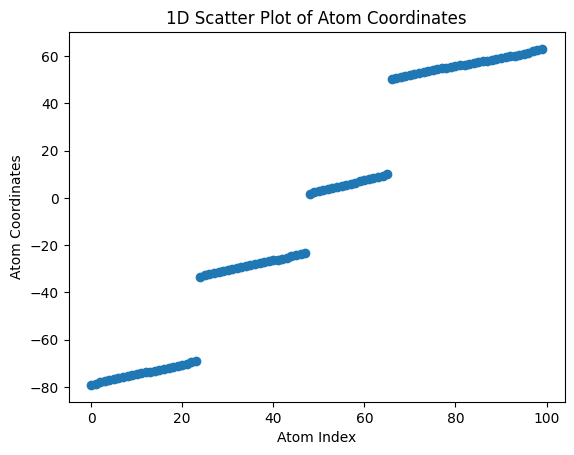

In [599]:
coordinates = atom_coordinates.coordinates.detach().numpy()

plt.scatter(range(len(coordinates)), np.sort(coordinates))
plt.xlabel('Atom Index')
plt.ylabel('Atom Coordinates')
plt.title('1D Scatter Plot of Atom Coordinates')
plt.show()

In [600]:
stable_coordinates = AtomCoordinates(100)
stable_conformations = simulate_stable_conformations(stable_coordinates(), lennard_jones_potential, num_iterations=5000)
coordinates = stable_conformations.data.numpy()

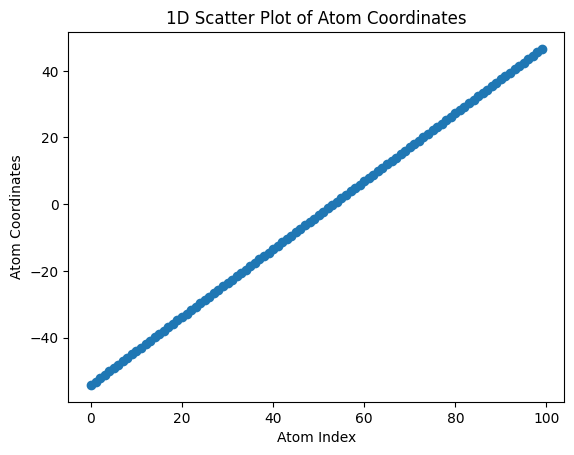

In [601]:
plt.scatter(range(len(coordinates)), np.sort(coordinates))
plt.xlabel('Atom Index')
plt.ylabel('Atom Coordinates')
plt.title('1D Scatter Plot of Atom Coordinates')
plt.show()

In [603]:
stable_coordinates = AtomCoordinates(100)
stable_conformations = simulate_stable_conformations(stable_coordinates(), force_field, num_iterations=5000)
coordinates = stable_conformations.data.numpy()

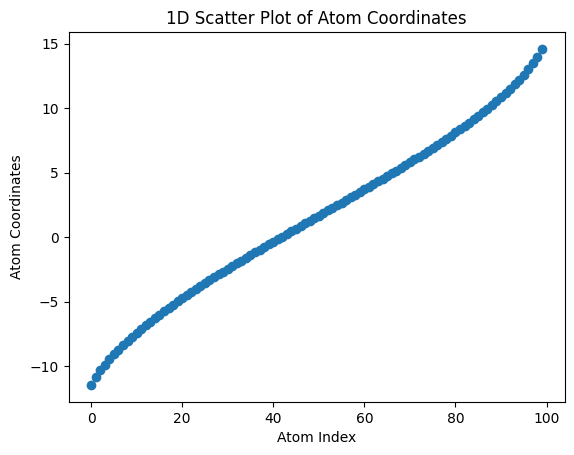

In [604]:
plt.scatter(range(len(coordinates)), np.sort(coordinates))
plt.xlabel('Atom Index')
plt.ylabel('Atom Coordinates')
plt.title('1D Scatter Plot of Atom Coordinates')
plt.show()

In [409]:
# Data
def lennard_jones_potential(r, eps=1e-1):
    return 1 / (r+eps)**12 - 1 / (r+eps)**6

def distances_matrix(coordinates):
    matrix_size = coordinates.shape[0]
    distances = torch.cdist(coordinates.view(-1, 1), coordinates.view(-1, 1))
    indices = torch.triu_indices(matrix_size, matrix_size, offset=1)
    distances = distances[indices[0], indices[1]]
    return distances

def simulate_stable_conformations(atom_coordinates, force_field=lennard_jones_potential, num_iterations=1000, lr=0.01):
    optimizer = optim.Adam([atom_coordinates], lr=lr)
    
    for iteration in range(num_iterations):
        potential_energy = torch.sum(force_field(distances_matrix(atom_coordinates)))

        optimizer.zero_grad()
        potential_energy.backward(retain_graph=True)
        torch.nn.utils.clip_grad_norm_(atom_coordinates, 1)
        optimizer.step()

        if iteration % 500 == 0:
            print(f"Iteration {iteration}, Potential Energy: {potential_energy.item()}")

    return atom_coordinates

In [235]:
atom_coordinates()

Parameter containing:
tensor([  5.4747, -33.2122,  31.9448, -26.0857,  -7.7603,   8.5290,  41.1075,
        -32.1942,  24.8183,  -1.6518,   7.5109, -27.1038, -18.9592,  -6.7422,
         30.9267,  13.6194, -16.9230,  32.9629, -22.0134,  44.1618,  26.8544,
          3.4386, -23.0315, -34.2304,  47.2159,  50.2705, -15.9049, -25.0677,
         43.1437, -49.5041,   4.4567, -46.4474, -47.4654, -24.0496,  11.5832,
         12.6013, -13.8688,  14.6374,  25.8363,  19.7278,  39.0713, -40.3388,
          6.4928,  29.9086, -42.3751,  -4.7061, -36.2666,  16.6736,  -5.7241,
        -29.1400, -44.4111,  10.5651,  36.0172,  46.1980,  42.1257, -12.8507,
         37.0352, -35.2485,   1.4024,  21.7640,  23.8002,  20.7459,  49.2521,
         17.6917,   9.5471, -17.9411,  38.0533,  34.9991,  28.8906, -37.2846,
        -39.3207, -28.1219,  15.6555, -11.8326, -14.8869, -43.3931,  -3.6880,
         22.7821,  -8.7784,  45.1799,   2.4205,   0.3843, -38.3027, -30.1580,
        -10.8146,  40.0895,  -9.7965, -41.

In [266]:
stable_conformations

Parameter containing:
tensor([-13.3776,  33.4538, -52.0649, -31.7035, -32.7210,   6.9835, -44.9387,
         47.7100, -29.6673, -39.8479,  17.1645,  16.1468,  21.2372, -25.5948,
         20.2189,  38.5443,  27.3457, -37.8119, -49.0112,  18.1829,  10.0384,
          9.0198,   2.9113, -41.8839, -27.6310, -46.9748, -53.0855, -36.7934,
        -15.4139, -21.5224, -20.5041, -45.9563,  42.6163,  11.0559,   0.8752,
        -47.9924, -38.8301,  14.1107,  23.2735,  13.0921, -40.8662, -22.5404,
         28.3635, -26.6127,  35.4900, -10.3236,   8.0023,  15.1283,  -6.2512,
        -23.5588, -16.4320, -51.0471,  40.5807,  12.0744,  25.3093,   1.8936,
        -19.4864,  45.6712, -28.6488, -18.4682,  36.5084,  32.4361,  34.4724,
        -33.7403,  30.3999,  37.5264, -17.4501,  -3.1969, -14.3960,  22.2549,
         -0.1426, -12.3599,  41.5991,   4.9473, -24.5763,  -8.2873, -34.7571,
         -2.1789,  -5.2331,  -9.3055, -43.9201, -35.7757,   5.9662,  -7.2694,
        -42.9025,  44.6530, -30.6850,   3.

In [7]:
a = torch.tensor([1., 4., 7.])
b = torch.tensor([2., 3., 4.])
dis = torch.cdist(a.view(-1, 1), b.view(-1, 1))
print(dis)

tensor([[1., 2., 3.],
        [2., 1., 0.],
        [5., 4., 3.]])


In [176]:
a = torch.tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
b = torch.tensor([[10, 10, 10], [10, 10, 10], [10, 10, 10]])
torch.tril(a, diagonal=-1) + torch.triu(b, diagonal=0)

tensor([[10, 10, 10],
        [ 4, 10, 10],
        [ 7,  8, 10]])

In [164]:
a.view(-1)

tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [404]:
# Create a square matrix
matrix_size = 5
matrix = torch.randn(matrix_size, matrix_size)

# Get the upper triangle indices
upper_triangle_indices = torch.triu_indices(matrix_size, matrix_size, offset=1)

# Slice the upper triangle of the matrix
upper_triangle_values = matrix[upper_triangle_indices[0], upper_triangle_indices[1]]

print("Original Matrix:")
print(matrix)

print("\nUpper Triangle Values:")
print(upper_triangle_values)

Original Matrix:
tensor([[-0.1052,  0.3620,  0.2989,  0.7137,  0.3318],
        [ 1.1346,  1.2919,  0.7832, -0.4691, -0.6315],
        [ 0.2741, -0.9424,  0.7661, -0.1261, -1.1756],
        [-2.1126,  1.6244, -0.9152,  0.5843, -1.8754],
        [-0.7198, -0.6665,  2.1563, -0.0958,  0.4065]])

Upper Triangle Values:
tensor([ 0.3620,  0.2989,  0.7137,  0.3318,  0.7832, -0.4691, -0.6315, -0.1261,
        -1.1756, -1.8754])
